In [1]:
%matplotlib inline
import xarray as xr
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os 
import scipy 

In [3]:
write_direc = '/gcs/rhg-data/climate/downscaled/workdir'

In [4]:
from utils import get_sample_data

In [9]:
# pip install git+https://github.com/dgergel/xsd.git@pointwisedownscaler_interimfix

In [10]:
from skdownscale.pointwise_models import PaddedDOYGrouper

In [5]:
training = get_sample_data('training')
targets = get_sample_data('targets')

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [6]:
ds_training = training['tmax'][train_slice].to_xarray()
ds_targets = targets['tmax'][train_slice].to_xarray()
ds_predict = training['tmax'][predict_slice].to_xarray()

apply `PaddedDOYGrouper` to get day groups

In [63]:
day_groups = {}
day_groups['targets'] = dict(list(PaddedDOYGrouper(targets['tmax'][train_slice])))
day_groups['training'] = dict(list(PaddedDOYGrouper(training['tmax'][train_slice])))
day_groups['predict'] = dict(list(PaddedDOYGrouper(training['tmax'][predict_slice])))

use June 1st for example day group 

In [64]:
dayofyear = 152 # June 1st 
# doy_group = doy_group_list[dayofyear]

build CDFs of obs, targets and future data 

In [66]:
def build_cdf(day_group_list, dayofyear, variable='tmax'): 
    df = day_group_list[dayofyear].to_frame()
    
    # create counts
    df_stats = df.groupby(variable)[variable].agg('count').pipe(pd.DataFrame).rename(columns = {variable: 'frequency'})
    
    df_stats['pdf'] = df_stats['frequency'] / sum(df_stats['frequency'])
    df_stats['cdf'] = df_stats['pdf'].cumsum()
    df_stats = df_stats.reset_index()
    
    return df_stats

In [67]:
df_stats = {}
df_stats['targets'] = build_cdf(day_groups['targets'], dayofyear=dayofyear)
df_stats['training'] = build_cdf(day_groups['training'], dayofyear=dayofyear)
df_stats['predict'] = build_cdf(day_groups['predict'], dayofyear=dayofyear)

<AxesSubplot:xlabel='tmax'>

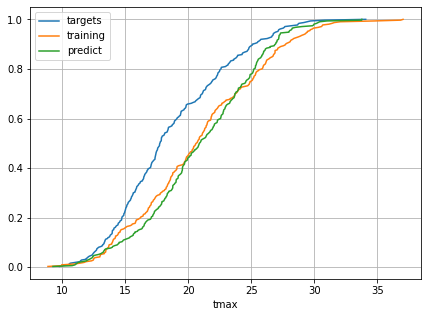

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
df_stats['targets'].plot(x = 'tmax', y = ['cdf'], grid = True, ax=ax, label=['targets'])
df_stats['training'].plot(x = 'tmax', y = ['cdf'], grid = True, ax=ax, label=['training'])
df_stats['predict'].plot(x = 'tmax', y = ['cdf'], grid = True, ax=ax, label=['predict'])


In [ ]:
norm_cdf = scipy.stats.norm.cdf(x) # calculate the cdf - also discrete